# Decomposition of intrinsic network from resting-state fMRI
### Load and define all requirements

In [5]:
# import requirements
import numpy as np
import pandas as pd
import seaborn as sns
import pynipt as pn

from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from slfmri import io as slio

# Ignore warning message
import warnings
warnings.filterwarnings('ignore')

# Load datasets
print(f'PyNIPT v{pn.__version__}')
pipe = pn.load('../', verbose=False)
pipe.set_package(0)

mask_path = '../Template/Rat_CAMRI_400um_MASK_v2-1.nii.gz'
temp_path = '../Template/Rat_Paxinos_200um_Template.nii.gz'

oput_pm = slio.PathMan('../Results/UNCCH_CAMRI/130_FeatureDetection')

# Define functions

def DL_decomposition(input_path, n_comp, r_path='./'):
    from nilearn.decomposition import DictLearning
    n_comp_str = str(n_comp).zfill(3)
    r_fname = f'DL_{n_comp_str}comp.nii.gz'
    output_path = os.path.join(r_path, r_fname)
    if not os.path.exists(output_path):
        dl_params = dict(memory='nilearn_cache', 
                     memory_level=2,   
                     mask=mask_path,
                     random_state=0,
                     n_epochs=1,
                     n_jobs=-1,
                     n_components=n_comp,
                     verbose=0,
                     high_pass=None,
                     low_pass=None,
                     smoothing_fwhm=None,
                     t_r=2)
        dset_list = pipe.get_dset(input_path).df.Abspath.tolist()
        est = DictLearning(**dl_params)
        est.fit(dset_list)
        comp_img = est.components_img_
        comp_img.header['qform_code'] = 1
        comp_img.header['sform_code'] = 0
        if not os.path.exists(r_path):
            os.mkdir(r_path)
        comp_img.to_filename(output_path)
    else:
        pass
    

def concat_data(list_of_paths, mask_path):
    # concat data into DataFrame
    mask_img = nib.load(mask_path)
    mask_idx = np.nonzero(mask_img.dataobj)
    
    df = pd.DataFrame()
    for p in tqdm(list_of_paths):
        cond_img = nib.load(p)
        cond_data = np.asarray(cond_img.dataobj)[mask_idx]
        n_comp = cond_data.shape[-1]
        for i, col in enumerate(cond_data.T):
            col_name = f'{str(n_comp).zfill(3)}_comp{str(i).zfill(3)}'
            df[col_name] = col
    return df

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    return dendrogram(linkage_matrix, **kwargs)

def jaccard_index(data1, data2):
    data1 = (data1 > 0).astype(int)
    data2 = (data2 > 0).astype(int)
    set_sum = data1 + data2
    
    numerator = set_sum[set_sum == 2].astype(int).sum()
    denominator = set_sum[set_sum > 0].astype(int).sum()
    return numerator / denominator

def standardize(data):
    return (data - data.mean()) / data.std()

def threshold(data, pval):
    data[data < norm.ppf(1 - pval)] = 0
    return data

def draw_graph(G, partision, prog='neato', thr=0, pos=None, label=True):
    import matplotlib as mpl
    
    norm = mpl.colors.Normalize(vmin=-0.6, vmax=0.6)
    scalarMap = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.jet)
    
    # define the colormap
    cmap = plt.cm.hsv
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # force the first color entry to be grey
    cmaplist[0] = (.5, .5, .5, 1.0)

    # create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

    # define the bins and normalize
    n_comm = np.max(list(partision.values()))
    bounds = np.linspace(0, n_comm-1, n_comm)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    
    fig = plt.figure(1,figsize=(50,50), dpi=100) 
    axes = fig.add_subplot(111)
    
    if pos is None:
        pos = nx.nx_agraph.graphviz_layout(G, prog=prog)
        
    color = G.degree()
    
    if label:
        label = {}
        pos_higher = {}
        for i, node in enumerate(G.nodes()):
            corrd = pos[node]
            pos_higher[i] = (corrd[0], corrd[1])
            label[i] = node
        nx.draw_networkx_labels(G, pos_higher, label, font_size=8)
        
    edge_colors = []
    for e in G.edges(data=True):
        if abs(e[2]['corr']) > thr:
            edge_colors.append(scalarMap.to_rgba(e[2]['corr']))
        else:
            edge_colors.append('gray')

    
    nx.draw_networkx_nodes(G, pos=pos,
                           node_color=list(partision.values()), cmap=cmap)
            
    nx.draw_networkx_edges(G, pos=pos, edge_color=edge_colors, 
                           width=[abs(e[2]['corr']) for e in G.edges(data=True)])
    axes.set_axis_off()
    fig.set_facecolor('white')
    
def draw_jointplot(data, compA, compB):
    data = data.copy()
    data[data == 0] = np.nan
    g = sns.jointplot(x=compA, y=compB, data=data, color='k',size=10)
    g.ax_joint.get_xaxis().set_visible(False)
    g.ax_joint.get_yaxis().set_visible(False)
    
class DualReg:
    """
    Dual regression integration using QR decomposition
    """
    def __init__(self, data, model):
        """
        data: VxT matrix where V is the number of voxels, T is the number of timepoints
        model: VxF matrix where V is the number of voxels, F is the number of spatial features
        """
        # private
        self._data = data
        self._model = model
        self._Tt, self._Pt = None, None
        self._Ts, self._Ps = None, None
        self._Coefs, self._Coeft = None, None
        
    def fit(self, pval=None):
        """
        fit data to model
        """
        self._dual_regression(pval)
        
    def _dual_regression(self, pval=None):
        """
        Perform spatial regression followed by the temporal regression using QR decomposition
        """
        from slfmri import filter as slftl
        from scipy import stats
        model = self._model
        
        predicted_t, self._Coeft = slftl.linear_regression(self._data, model, method='svd', return_beta=True)
        v, f = model.shape
        dof = v - f
        mse_t = np.square(predicted_t.sum(-1) - self._data).sum(-1) / float(dof)
        diag_t = np.linalg.inv(np.dot(model.T, model)).diagonal()
        se_t = np.sqrt((mse_t * np.concatenate([diag_t[:, np.newaxis]], axis=-1)).T)
        
        t_t = self._Coeft.copy()
        t_t[se_t == 0] = 0
        t_t[np.nonzero(se_t)] /= se_t[np.nonzero(se_t)]
        
        self._Tt = t_t
        self._Pt = 2 * (1 - stats.t.cdf(abs(t_t), df=dof))
        
        model = self._Coeft
        predicted_s, self._Coefs = slftl.linear_regression(self._data.T, model, method='svd', return_beta=True)
        v, f = model.shape
        dof = v - f
        mse_s = np.square(predicted_s.sum(-1) - self._data.T).sum(-1) / float(dof)
        diag_s = np.linalg.inv(np.dot(model.T, model)).diagonal()
        se_s = np.sqrt((mse_s * np.concatenate([diag_s[:, np.newaxis]], axis=-1)).T)
        
        t_s = self._Coefs.copy()
        t_s[se_s == 0] = 0
        t_s[np.nonzero(se_s)] /= se_s[np.nonzero(se_s)]
        
        self._Ts = t_s
        self._Ps = 2 * (1 - stats.t.cdf(abs(t_s), df=dof))
        if pval is not None:
            self._Coeft[self._Pt > pval] = 0
            self._Coefs[self._Ps > pval] = 0
    
    @property
    def coef_(self):
        """
        Coefficients for each spatial and temporal features
        """
        return dict(spatial=self._Coefs,  # VxF matrix
                    temporal=self._Coeft) # FxT matrix
    
    @property
    def predicted(self):
        """
        Predicted data from dual regression

        Return:
            np.ndarray (2D): VxT matrix
        """
        return np.dot(self._Coefs, self._Coeft)
    
    @property
    def decoded(self):
        """
        Decoded data using model
        
        Return:
            np.ndarray (2D): VxT matrix
        """
        return np.dot(self._model, self._Coeft)

    @property
    def error(self):
        """
        The sum of square of difference between original data and predicted data
        
        Return:
            np.ndarray (1D)
        """
        return np.square(self._data - self.predicted).sum(0)
    
def dualreg_randseg(dset, step_code, output_path, model, mask, n_sample=3, pval=None,
                    size_sample=100, stdout=None, stderr=None):
    """ 
    This item need to be redesigned for interface
    This code takes the mean value of data into account as a regressor to handle the baseline
    """
    from tqdm.notebook import tqdm
    
    if stdout is None:
        stdout = sys.stdout
    if stderr is None:
        stderr = sys.stderr

    class_id = 1
    stdout.write('[UNCCH_CAMRI] DualRegression and ICC:\n')
    try:
        if not os.path.exists(output_path):
            os.mkdir(output_path)
        stdout.write(f'Model: {model}\n')
        model_nii = nib.load(model)
        stdout.write(f'Mask: {mask}\n')
        mask_nii = nib.load(mask)
        mask_idx = np.nonzero(mask_nii.dataobj)
        model_data = np.asarray(model_nii.dataobj)[mask_idx]
        
        for subj in tqdm(dset.params[class_id].subjects):
            subj_path = os.path.join(output_path, subj)
            if not os.path.exists(subj_path):
                os.mkdir(subj_path)
            stdout.write(f'  Load {subj}...\n')
            list_of_files = dset(class_id, steps=[step_code], subjects=subj).df.Abspath
            
            stdout.write(f'    Total number of files: {len(list_of_files)}...\n')
            if len(list_of_files) > 1:
                # concat files
                input_data = []
                onsets = []
                for oid, f in enumerate(list_of_files):
                    loaded_data = np.asarray(nib.load(f).dataobj)[mask_idx]
                    input_data.append(loaded_data)
                    if oid == 0:
                        onsets.append(0)
                    else:
                        onsets.append(input_data[oid-1].shape[-1] + onsets[-1])
                input_data = np.concatenate(input_data, -1)
                max_size = input_data.shape[1] - size_sample
                onsets = [o for o in onsets if o <= max_size]
            else:
                input_nii = nib.load(list_of_files[0])
                input_data = np.asarray(input_nii.dataobj)[mask_idx]
                onsets = None
            n_frame = input_data.shape[-1]
            stdout.write(f'    Total number of frames: {n_frame}\n')
            
            model = np.c_[input_data.mean(-1), model_data]
            model = (model / abs(model).max(0))
            
            # random sampling
            if len(list_of_files) > 1:
                sampled_onsets = np.random.choice(onsets, n_sample, replace=False)
            else:
                sampled_onsets = np.random.choice(n_frame - size_sample - 1, n_sample, replace=False)
            for time, onset in enumerate(sampled_onsets):
                fname = os.path.join(subj_path, f'{subj}_run-{time + 1}_cap')
                if not os.path.exists(f'{fname}.nii.gz'):
                    trial_data = input_data[..., onset:onset+size_sample]
                    dr = DualReg(trial_data.T, model)
                    dr.fit(pval)
                    coef_trace, est_models = dr.coef_['temporal'], dr.coef_['spatial']
                    output_data = np.zeros(list(mask_nii.shape) + [model.shape[-1]])
                    output_data[mask_idx] = est_models
                    output_nii = nib.Nifti1Image(output_data, affine=input_nii.affine)
                    output_nii.header['qform_code'] = 1
                    output_nii.header['sform_code'] = 0
                    output_nii.to_filename(f'{fname}.nii.gz')
                    pd.DataFrame(coef_trace).to_csv(f'{fname}.tsv', sep='\t')
                    stdout.write(f'{time+1}..')
                else:
                    pass
            stdout.write('\n')
        stdout.write('Done..\n')
    except:
        import traceback
        stderr.write('[ERROR] Failed.\n')
        traceback.print_exception(*sys.exc_info(), file=stderr)
        return 1
    return 0

def get_coord_center_of_mass(func_obj):
    """ Return center of mass coordinate on Paxinos system """
    from scipy import ndimage
    
    mask = np.array(func_obj.dataobj).astype(bool)
    mask_com = ndimage.measurements.center_of_mass(mask)
    affine = func_obj.affine.copy()
    com_coord = affine[:3, :3].dot(mask_com) + affine[:3, 3]
    return com_coord * np.array([1, 1, -1]) - np.array([0, 0.36, -7])

PyNIPT v0.2.3


### Extracting intrinsic network features using MultiScale Dictionary Learning Decomposition
<center>For first time only</center>

In [7]:
## 0.01 - 0.1 with 6 dof motion parameters
code = 'A' # Done
suffix = 'bp001010'

# 0.01 - 0.2 with 6 dof motion parameters
# code = 'B'
# suffix = 'bp001020'

input_path=f'05{code}'

r_path = f'../Results/UNCCH_CAMRI/11{code}_DictionaryLearningDecomp-{suffix}'
# for i, n_comp in tqdm(enumerate(range(5, 105, 5)), total=20):
#     DL_decomposition(input_path, n_comp, r_path=r_path)

### Preparing datasets required to proceed next steps

#### List of objects
1. dl_data : pandas DataFrame contains masked voxel values for each DL components (n=1050)
2. corr_matrix : Pairwise Pearson's Correlation Matrix of object 1.
3. jaccard_matrix : Pairwise Jaccard Index Matrix of object 1

In [8]:
# Mask index
mask_img = nib.load(mask_path)
mask_idx = np.nonzero(mask_img.dataobj)

dls = dict()
crs = dict()
jcs = dict()

# Generate/Load dataset
fname = oput_pm(f'DL_DataFrame_{code}.tsv')
if not os.path.exists(fname):
    dl_dset = pipe.get_dset(f'11{code}').df.Abspath.tolist()
    dl_data = concat_data(dl_dset, mask_path)
    dl_data.to_csv(fname, sep='\t')
else:
    dl_data = pd.read_csv(fname, sep='\t', index_col=0)
dls[code] = dl_data

# Generate/Load correlation matrix
fname = oput_pm(f'DL_PearsonCorr_{code}.tsv')
if not os.path.exists(fname):
    corr_matrix = dl_data.corr()
    corr_matrix.to_csv(fname, sep='\t')
else:
    corr_matrix = pd.read_csv(fname, sep='\t', index_col=0)
crs[code] = corr_matrix

# Generate/Load Jaccard matrix
fname = oput_pm(f'DL_Jaccard_{code}.tsv')
if not os.path.exists(fname):
    from functools import partial
    stack = []
    for d in tqdm(dl_data.values.T):
        jfunc = partial(jaccard_index, data2 = d)
        stack.append(np.apply_along_axis(jfunc, 0, dl_data))
    jaccard_matrix = pd.DataFrame(stack)
    jaccard_matrix.columns = dl_data.columns
    jaccard_matrix.index = dl_data.columns
    jaccard_matrix.to_csv(fname, sep='\t')
else:
    jaccard_matrix = pd.read_csv(fname, sep='\t', index_col=0)
jcs[code] = jaccard_matrix

### Threshold similarity matrices before combining for clustering

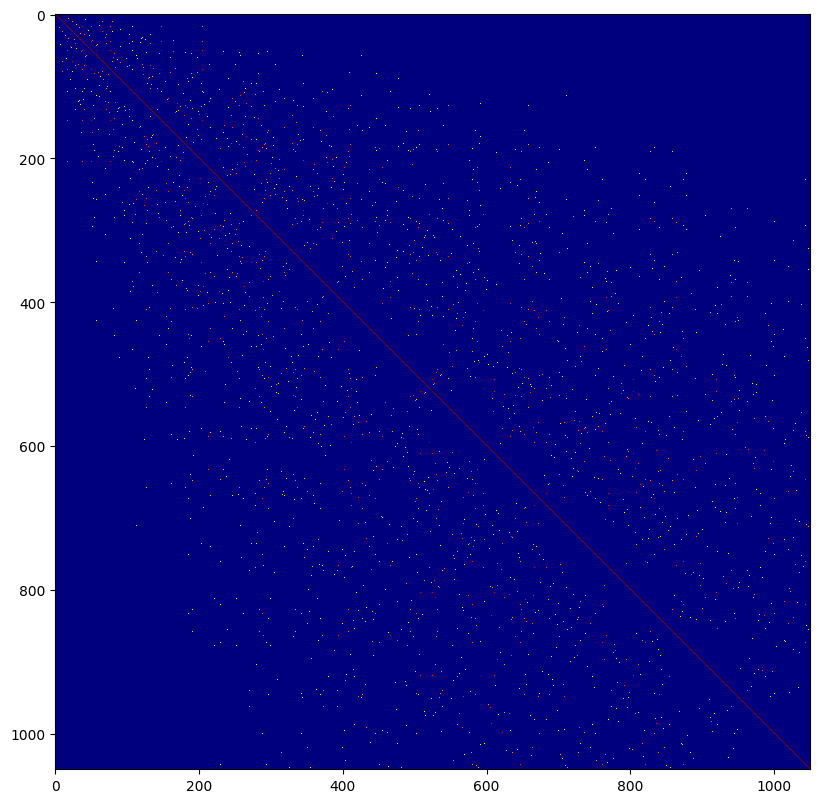

In [9]:
corr_matrix[corr_matrix < 0.7] = 0
jaccard_matrix[jaccard_matrix < 0.7] = 0

merged_matrix = np.multiply(corr_matrix.values, 
                            jaccard_matrix.values)
merged_matrix = pd.DataFrame(merged_matrix, 
                             columns=corr_matrix.columns, 
                             index=corr_matrix.columns)
merged_matrix /= abs(merged_matrix).max()

fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=100)
ax.imshow(merged_matrix.values, cmap='jet', 
          interpolation='nearest')
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)

### Testing of community detection
- The features that identified from multi-scale approaches are not clearly clustered in a single trial.
- The results can be varied along the multiple trials

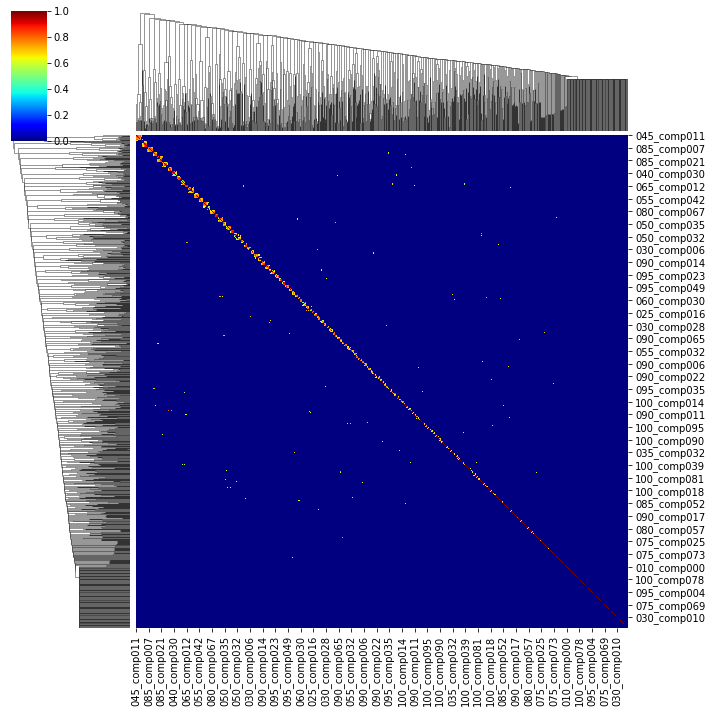

In [10]:
import seaborn as sns
sns.clustermap(merged_matrix, cmap='jet')

Name: 
Type: Graph
Number of nodes: 1050
Number of edges: 2234
Average degree:   4.2552


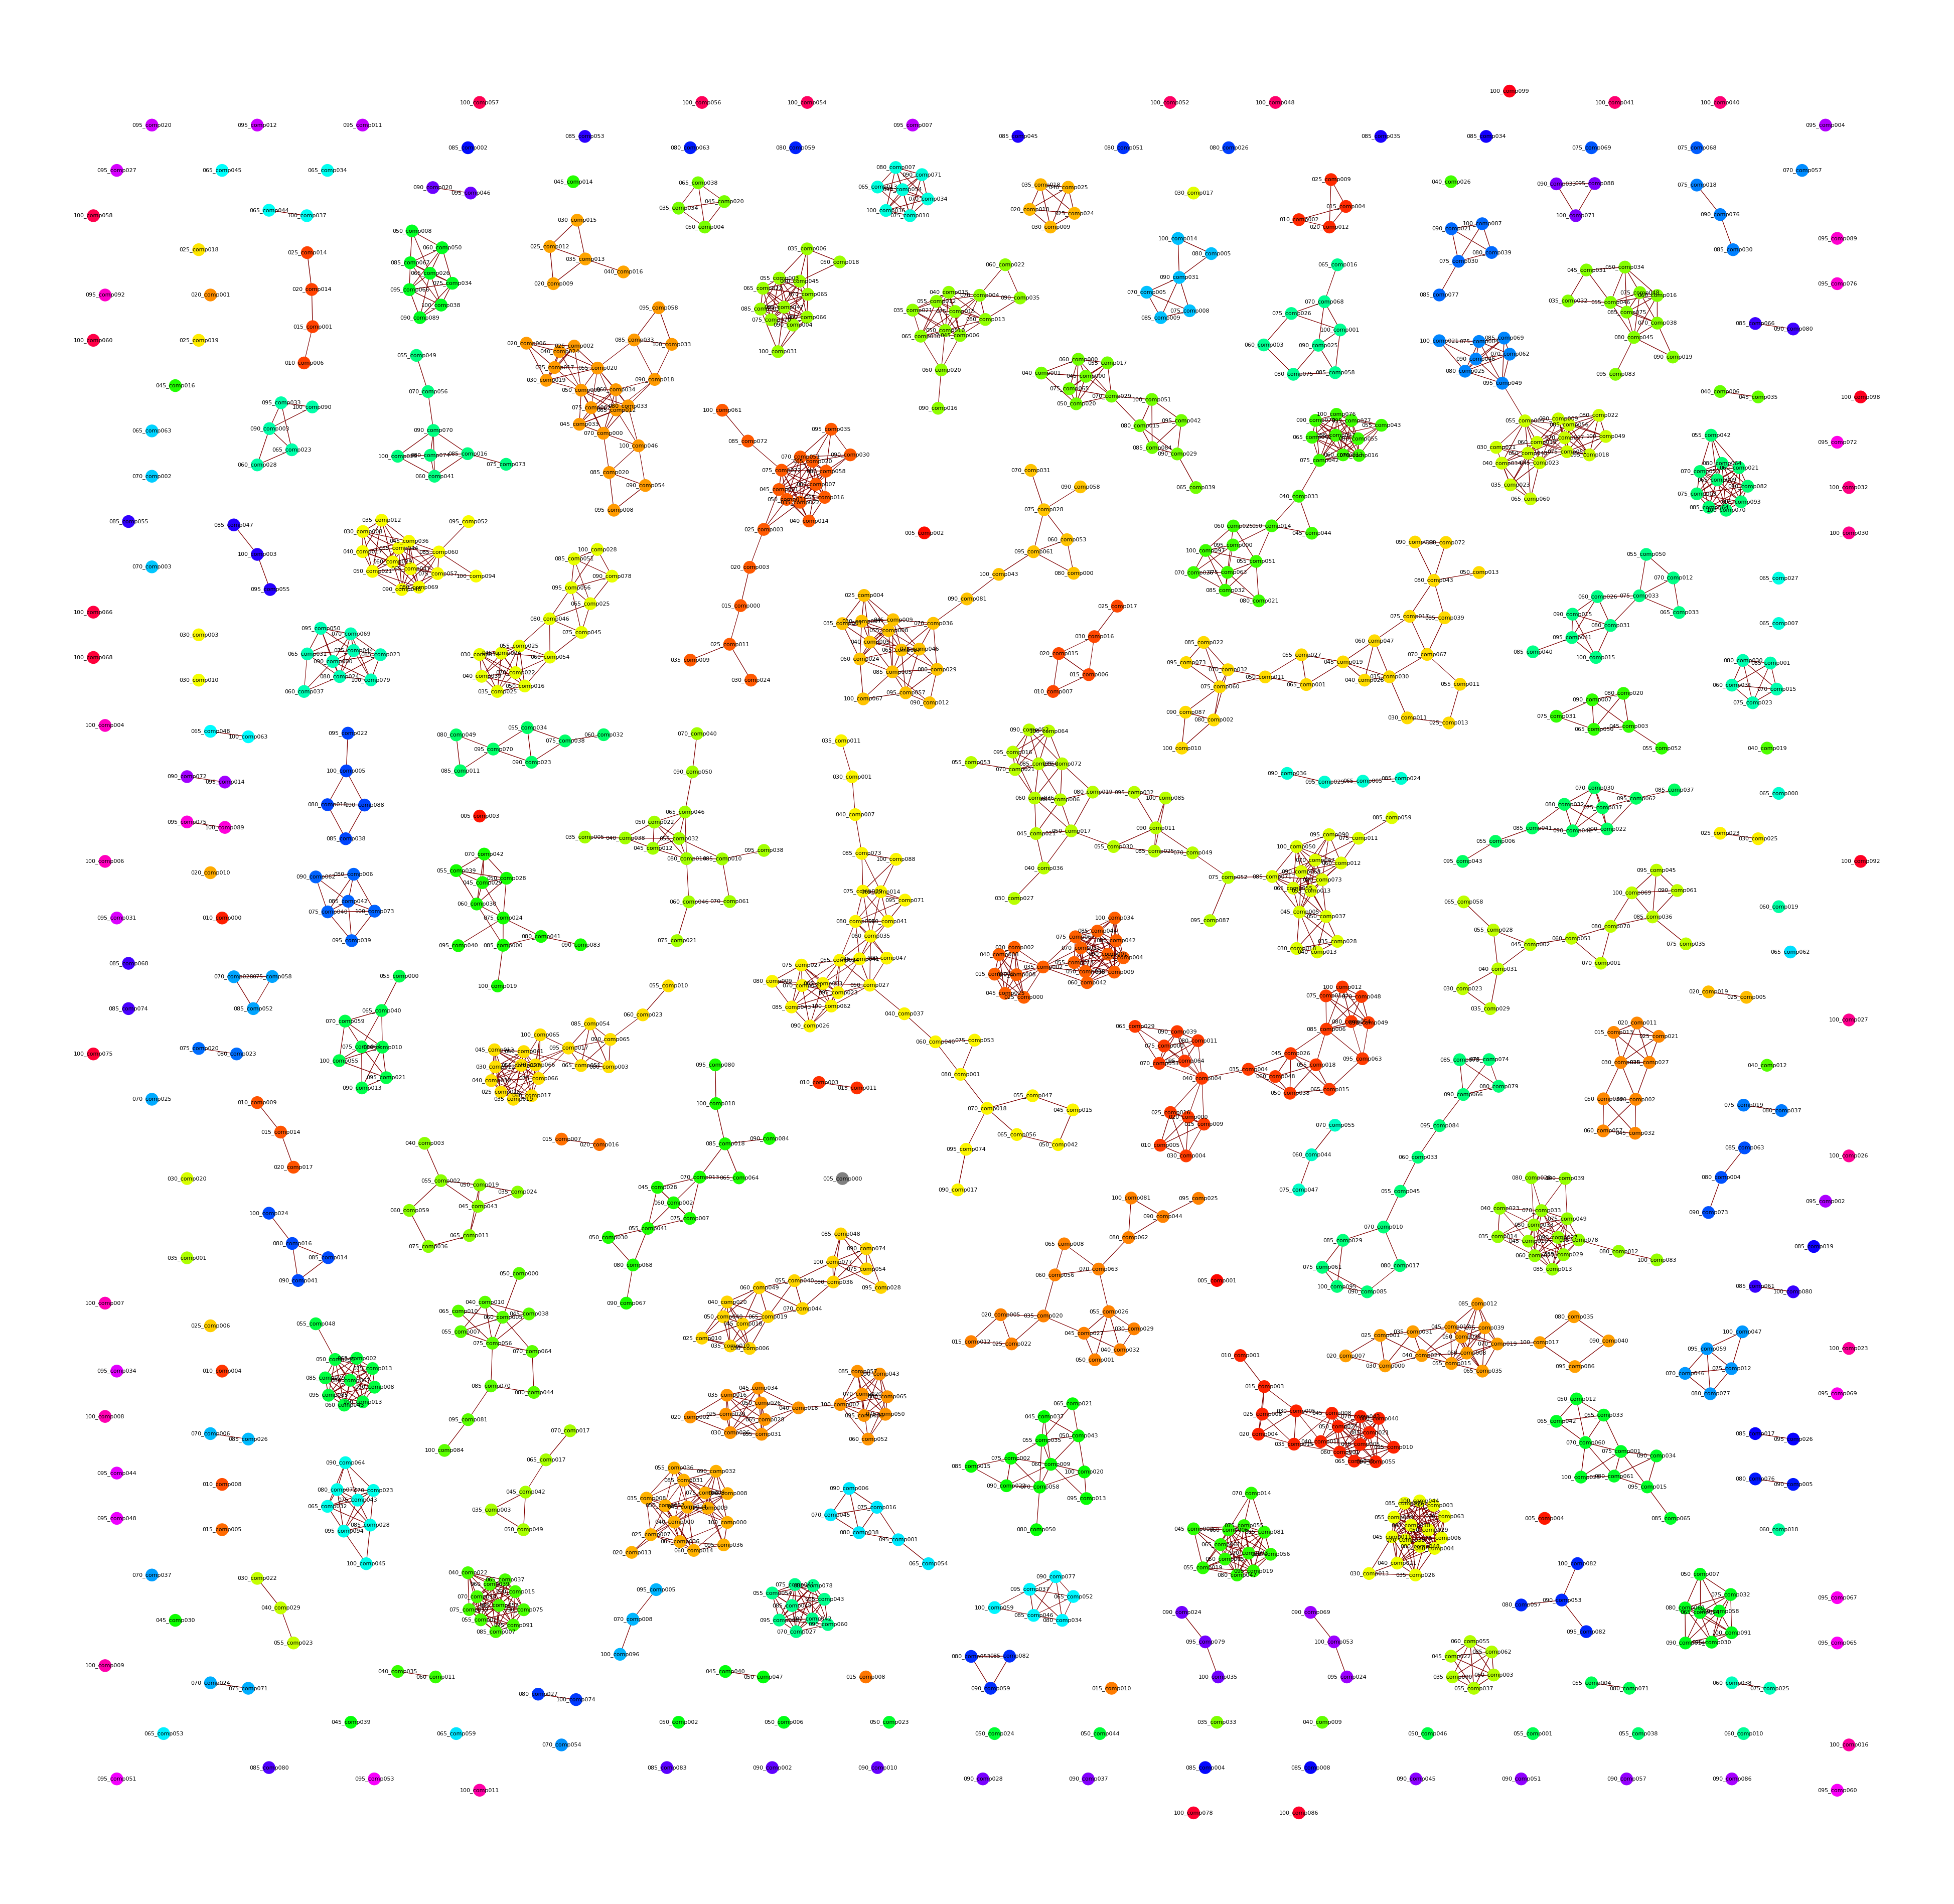

In [11]:
import networkx as nx

G = nx.Graph()
G.add_nodes_from(merged_matrix)

# adding weighted edge
for u, v in np.transpose(np.nonzero(np.tril(merged_matrix.values, k=-1))):
    u_idx = corr_matrix.columns[u]
    v_idx = corr_matrix.columns[v]
    G.add_edge(u_idx, v_idx, corr=corr_matrix.loc[u_idx, v_idx])
    
from community import community_louvain
partision = community_louvain.best_partition(G)

print(nx.info(G))

draw_graph(G, partision)

### Iterating the community detection and calculate probability of communication between features

In [12]:
# Iteration and find the frequency of comminitization between nodes
data_path = oput_pm(f'group_features_{code}.npy')
if os.path.exists(data_path):
    prob_matrix = np.load(data_path)
else:
    niter = 5000
    freq_com = dict()
    for p in tqdm(range(niter)):
        part = community_louvain.best_partition(G)
        for i, com in part.items():
            if i not in freq_com.keys():
                freq_com[i] = []
            freq_com[i].extend([j for j, c in part.items() if c == com])

    prob_matrix = np.zeros([1050, 1050])
    prob_matrix = pd.DataFrame(prob_matrix, columns=freq_com.keys(), index=freq_com.keys())
    for c, val in tqdm(freq_com.items()):
        if len(val) == 0:
            pass
        else:
            for i in set(val):
                prob_matrix.loc[c, i] = (np.array(freq_com[c]) == i).sum()/niter
    np.save(data_path, prob_matrix)
    
prob_matrix = pd.DataFrame(prob_matrix, 
                           columns=merged_matrix.columns, 
                           index=merged_matrix.columns)

Name: 
Type: Graph
Number of nodes: 1050
Number of edges: 5831
Average degree:  11.1067


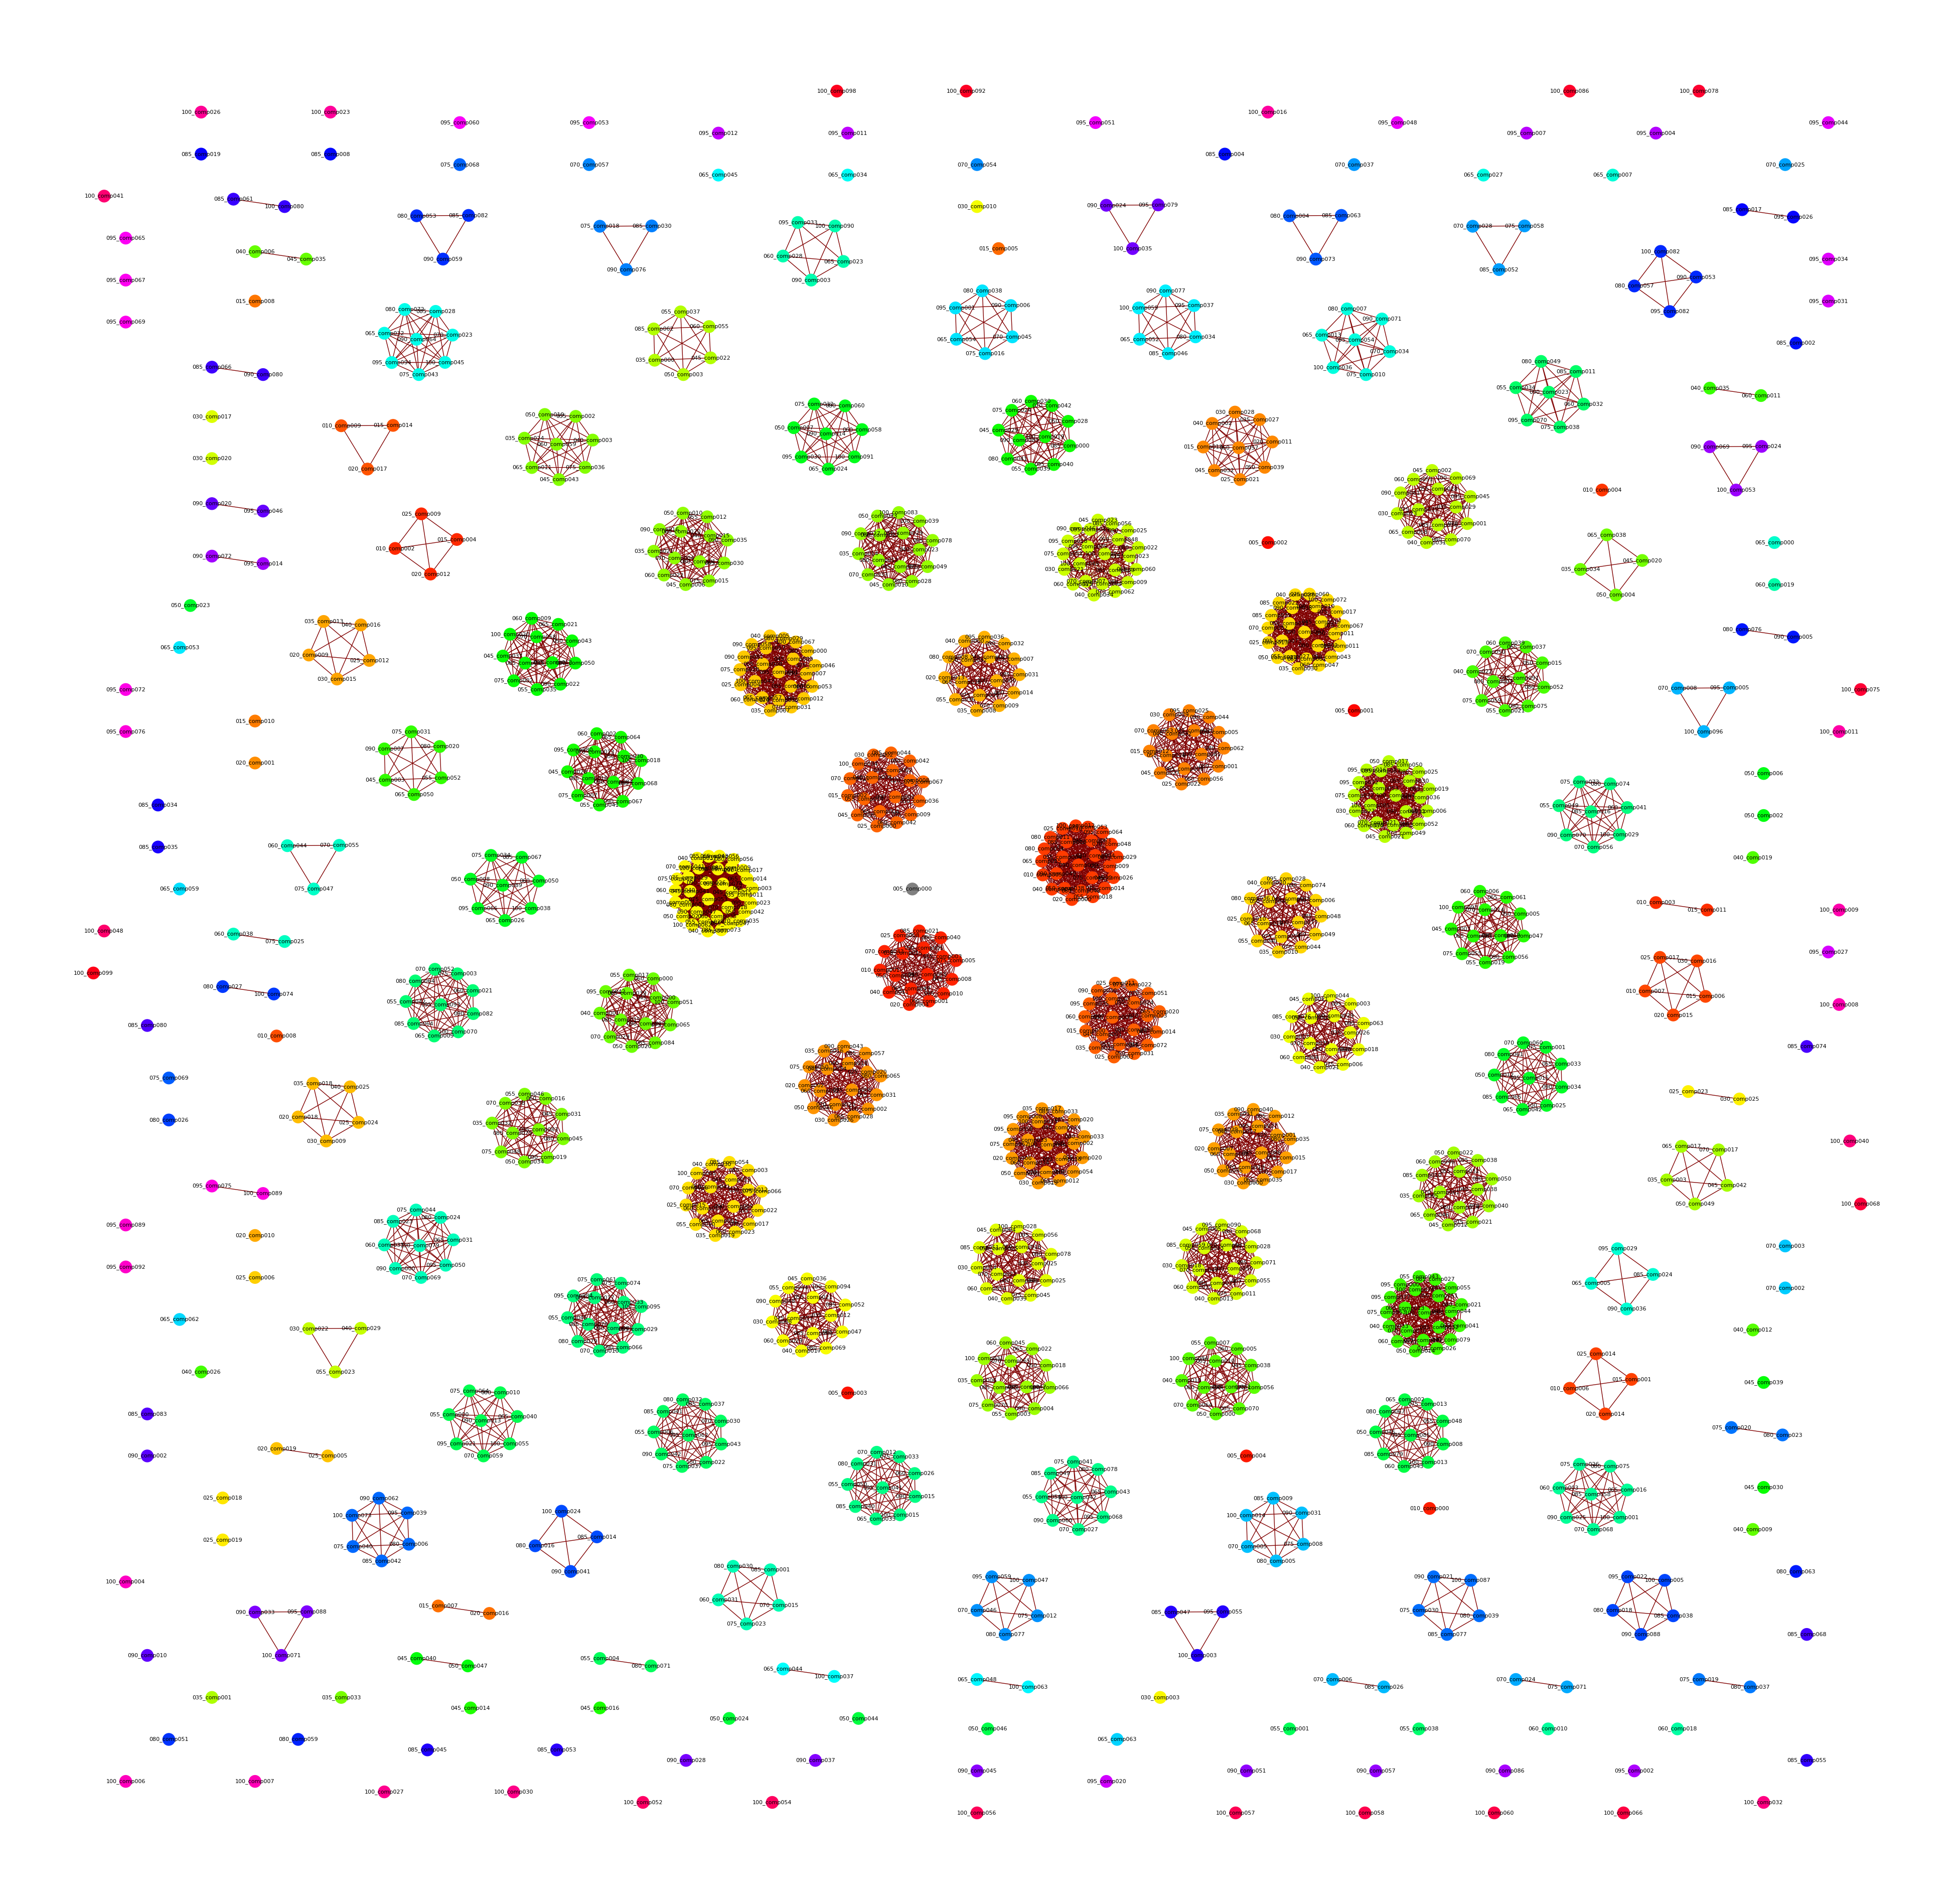

In [13]:
import networkx as nx

G_2lvl = nx.Graph()
G_2lvl.add_nodes_from(prob_matrix)

# adding weighted edge
for u, v in np.transpose(np.nonzero(np.tril(prob_matrix.values, k=-1))):
    u_idx = prob_matrix.columns[u]
    v_idx = prob_matrix.columns[v]
    G_2lvl.add_edge(u_idx, v_idx, corr=prob_matrix.loc[u_idx, v_idx])
    
from community import community_louvain
partision_2lvl = community_louvain.best_partition(G_2lvl)

print(nx.info(G_2lvl))
draw_graph(G_2lvl, partision_2lvl)

### Get identified clusters and save it to files

In [14]:
communities = dict()
for comp, comm_idx in partision_2lvl.items():
    if comm_idx not in communities.keys():
        communities[comm_idx] = []
    communities[comm_idx].append(comp)
print(f'Identified number of communities: {len(communities)}')
    
# Skip if you already performed this
import re
label_pattern = r'(?P<comp_n>[0-9]{3})_comp(?P<comp_id>[0-9]{3})'

source_path = f'../Results/UNCCH_CAMRI/11{code}_DictionaryLearningDecomp-{suffix}'
target_path = f'../Results/UNCCH_CAMRI/12{code}_DLPatternCommunitiesWithProb-{suffix}'

if not os.path.exists(target_path):
    os.mkdir(target_path)
fprox_map = dict()

for comm_idx, comps in tqdm(communities.items()):
    output_fname = f'community_{str(comm_idx).zfill(3)}.nii.gz'
    output_path = os.path.join(target_path, output_fname)
    
    if os.path.exists(output_path):
        pass
    else:
        comm_data = np.zeros(list(mask_img.shape) + [len(comps)])
        for i, c in enumerate(comps):
            comp_n, comp_id = re.match(label_pattern, c).groups()

            if comp_n not in fprox_map.keys():       # load image data
                fname = f'DL_{comp_n}comp.nii.gz'
                fpath = os.path.join(source_path, fname)
                fprox_map[comp_n] = nib.load(fpath)

            comp_img = fprox_map[comp_n]
            comm_data[..., i] = np.asarray(comp_img.dataobj)[..., int(comp_id)]


        comm_img = nib.Nifti1Image(comm_data, mask_img.affine)
        comm_img.header['qform_code'] = 1
        comm_img.header['sform_code'] = 0
        comm_img.to_filename(output_path)

Identified number of communities: 241


In [15]:
from scipy import stats

def add_frame(mask_idx, frame):
    x, y, z = mask_idx
    f = (np.ones(len(x)) * frame).astype(int)
    return x, y, z, f

label_pattern = r'community_(?P<comp_n>[0-9]{3}).nii.gz'

source_path = f'../Results/UNCCH_CAMRI/12{code}_DLPatternCommunitiesWithProb-{suffix}'
target_path = f'../Results/UNCCH_CAMRI/13{code}_SummarizedDLWithProb-{suffix}'

if not os.path.exists(target_path):
    os.mkdir(target_path)

ftmap_path = os.path.join(target_path, 'SpatioTemporalFeatureMaps.nii.gz')

if os.path.exists(ftmap_path):
    raw_model = nib.load(ftmap_path)
else:
    source_data = [f for f in os.listdir(source_path) if re.match(label_pattern, f)]

    # Select features that presented at least 4 times
    selected_features = dict([[l, c] for l, c in communities.items() if len(c) >= 4])

    output_data = np.zeros(list(mask_img.shape) + [len(selected_features)])
    for i, l in enumerate(tqdm(selected_features.keys())):
        fname = source_data[l]
        comm_id = re.match(label_pattern, fname).group()
        fpath = os.path.join(source_path, fname)
        comm_img = nib.load(fpath)
        comm_data_flt = np.asarray(comm_img.dataobj)[mask_idx]
        comm_data_flt_z = np.zeros(comm_data_flt.shape)

        n_smp = comm_data_flt.shape[-1]
        # standardize data
        for m in range(n_smp):
            m_data = comm_data_flt[..., m]
            m_data_z = standardize(m_data)
            m_data_z[m_data == 0] = 0
            comm_data_flt_z[..., m] = m_data_z

        if n_smp > 1:
            mn = comm_data_flt_z.mean(-1)
            sd = comm_data_flt_z.std(-1)
            t_map = mn / (sd / np.sqrt(n_smp))
            pp_map = 1 - stats.t.cdf(t_map, n_smp - 1)
            np_map = stats.t.cdf(t_map, n_smp - 1)
            mn[(pp_map > 0.025)&(np_map > 0.025)] = 0
            output_data[add_frame(mask_idx, i)] = mn
        else:
            comm_data_flt_z = standardize(comm_data_flt)
            comm_data_flt_z[comm_data_flt == 0] = 0
            output_data[add_frame(mask_idx, i)] = comm_data_flt_z[..., 0]

    raw_model = nib.Nifti1Image(output_data, mask_img.affine)
    raw_model.header['qform_code'] = 1
    raw_model.header['sform_code'] = 0

    raw_model.to_filename(ftmap_path)

In [16]:
selected_features = dict([[l, c] for l, c in communities.items() if len(c) >= 4])

# Generate table

## ICC and similarity between DR group average

---
test

In [17]:
import nibabel as nib
from slfmri import filter as slftl

def plot_them_all(a, b, slc=16, idx=0):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(a[:, ::-1, slc, idx].T, origin='lower', cmap='jet')
    axes[1].imshow(b[:, ::-1, slc, idx].T, origin='lower', cmap='jet')
    
def recon_img(data, mask_path):
    mask = nib.load(mask_path)
    new_img = np.zeros(list(mask.shape)+[data.shape[-1]-1])
    mask_idx = np.nonzero(mask.dataobj)
    
    new_img[mask_idx] = data[..., 1:]
    return new_img

def save_to_nib(data, affine):
    nii = nib.Nifti1Image(data, affine)
    nii.header['sform_code'] = 0
    nii.header['qform_code'] = 1
    return nii

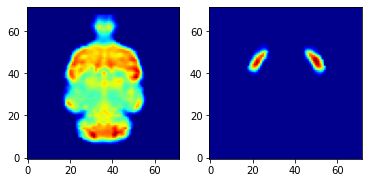

In [18]:
dset = pipe.get_dset('20A')
spl_arr = np.asarray(nib.load(dset[1].Abspath).dataobj)
mdl_arr = np.asarray(raw_model.dataobj)

plot_them_all(spl_arr, mdl_arr)

In [19]:
spl_data = spl_arr[mask_idx]
mdl_data = mdl_arr[mask_idx]

model = np.c_[spl_data.mean(-1), mdl_data]
model = (model / abs(model).max(0))

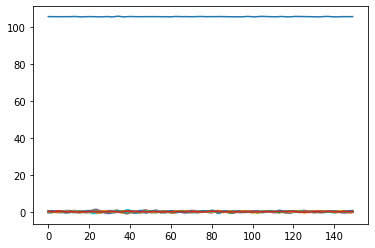

In [20]:
dr = DualReg(spl_data.T, model)
dr.fit()

fig = plt.plot(dr.coef_['temporal'])

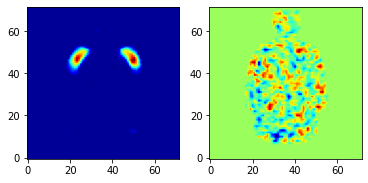

In [21]:
dr_img = recon_img(dr.coef_['spatial'], mask_path)
plot_them_all(mdl_arr, dr_img, slc=18, idx=0)

end

---

In [ ]:
# Skip this if you already performed
output_path = f'../Processing/UNCCH_CAMRI/06{code}_DualRegressionForICC-{suffix}'
dset = pipe.get_dset(f'05{code}')
dualreg_randseg(dset, f'05{code}', output_path, 
                raw_model.get_filename(), 
                mask_path, size_sample=150)

In [225]:
# debugging
code = 'G'
suffix = 'Debug_pval'

output_path = f'../Processing/UNCCH_CAMRI/06{code}_DualRegressionForICC-{suffix}'
step_pm = slio.PathMan(output_path)
dset = pipe.get_dset(f'20A')

mdl_data = np.asarray(raw_model.dataobj)[mask_idx]
for i, finfo in tqdm(dset):
    subj_pm = slio.PathMan(step_pm(finfo.Subject))
    oput_fname = subj_pm(finfo.Filename)
    fname = finfo.Filename.split('.')[0]
    ts_fname = subj_pm(f'{fname}.tsv')
    if os.path.exists(oput_fname):
        pass
    else:
        seg_nii = nib.load(finfo.Abspath)
        seg_data = np.asarray(seg_nii.dataobj)[mask_idx]
        model = np.c_[seg_data.mean(-1), mdl_data]
        model = (model / abs(model).max(0))

        dr = DualReg(seg_data.T, model)
        dr.fit(0.05)
        coef_trace, est_models = dr.coef_['temporal'], dr.coef_['spatial']
        output_data = np.zeros(list(mask_img.shape) + [model.shape[-1]])
        output_data[mask_idx] = est_models
        output_nii = nib.Nifti1Image(output_data, affine=seg_nii.affine)
        output_nii.header['qform_code'] = 1
        output_nii.header['sform_code'] = 0
        output_nii.to_filename(oput_fname)
        pd.DataFrame(coef_trace).to_csv(ts_fname, sep='\t')

In [23]:
def get_icc(results):
    '''get the Intraclass Correlation Coefficient (ICC)'''
    icc = results.cov_re / (results.cov_re + results.scale)
    return icc.values[0, 0]


def test_reliability(data, subj_ids):
    '''
    '''
    from functools import partial
    from scipy.stats import pearsonr
    
    avr = data.mean(0) # group average
    # testing whether the subject level components are correlated with its group average
    corr_to_avr = np.apply_along_axis(partial(pearsonr, y=avr), axis=1, arr=data)
    df = pd.DataFrame(dict(corr=corr_to_avr[:, 0], group=subj_ids))
    
    # Below code perform linear mixed model to estimate random effect for ICC analysis
    import statsmodels.formula.api as smf
    import statsmodels.api as sm
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        md = smf.mixedlm("corr ~ 1", df, groups=df["group"])
        mdf = md.fit()
    
    # The result will only present how the correlation values are consistant across subject.
    return get_icc(mdf)


def get_icc_results(dset, model_path, mask_path, output_fname):
    from scipy.stats import pearsonr
    if not os.path.exists(f'{output_fname}.nii.gz'):
        mask_idx = np.nonzero(nib.load(mask_path).dataobj)
        model_img = nib.load(model_path)
        model_data = np.asarray(model_img.dataobj)[mask_idx]

        results = dict(icc=[], similarity=[])
        est_model = np.zeros(model_data.shape)
        list_paths = dset.df.Abspath.tolist()
        subj_ids = dset.df.Subject.tolist()
        print('Loading data...')
        dataset = [np.asarray(nib.load(p).dataobj)[mask_idx][np.newaxis, ...] for p in list_paths]
        dataset = np.concatenate(dataset, axis=0)[..., 1:]
        print('Done...')
        
        for comp_idx in tqdm(range(model_data.shape[-1])):
            dataset_comp = dataset[..., comp_idx]
            results['icc'].append(test_reliability(dataset_comp, subj_ids))
            comp_grpavr = dataset_comp.mean(0)
            est_model[:, comp_idx] = comp_grpavr
            results['similarity'].append(pearsonr(comp_grpavr, 
                                                  model_data[..., comp_idx])[0])
        results_df = pd.DataFrame(results)
        results_df.to_csv(f'{output_fname}.tsv', sep='\t')

        mean_est_model = np.zeros(model_img.shape)
        mean_est_model[mask_idx] = est_model
        mean_est_model_img = nib.Nifti1Image(mean_est_model, model_img.affine, model_img.header)
        mean_est_model_img.to_filename(f'{output_fname}.nii.gz')
    else:
        results_df = pd.read_csv(f'{output_fname}.tsv', sep='\t', index_col=0)
        mean_est_model_img = nib.load(f'{output_fname}.nii.gz')
    return results_df, mean_est_model_img

In [26]:
code = 'E'

In [25]:
# Functions for statistic
def ttest(data, model):
    from slfmri import filter as slflt
    from scipy import stats
    predicted, coef = slflt.linear_regression(data, model, method='svd', return_beta=True)
    
    dof = model.shape[0] - model.shape[1]
    mse = np.square(predicted.sum(-1) - data).sum(-1) / float(dof)
    se = np.sqrt((mse * np.concatenate([np.linalg.inv(np.dot(model.T, model)).diagonal()[:, np.newaxis]], axis=-1)).T)

    t = coef.copy()
    if model.shape[-1] == 1:
        # one sample t-test
        t -= t.mean()  # against population mean
    t[se == 0] = 0
    t[np.nonzero(se)] /= se[np.nonzero(se)]
    p = 2 * (1 - stats.t.cdf(abs(t), df=dof))
    return coef, t, p

In [ ]:
# Debug

from scipy.stats import pearsonr

dset = pipe.get_dset(f'06{code}', ext='nii.gz')

mask_idx = np.nonzero(nib.load(mask_path).dataobj)
model_img = raw_model
# model_img = nib.load(model_path)
model_data = np.asarray(model_img.dataobj)[mask_idx]

results = dict(icc=[], similarity=[])
est_model = np.zeros(model_data.shape)
list_paths = dset.df.Abspath.tolist()
subj_ids = dset.df.Subject.tolist()
print('Loading data...')
dataset = [np.asarray(nib.load(p).dataobj)[mask_idx][np.newaxis, ...] for p in list_paths]
dataset = np.concatenate(dataset, axis=0)[..., 1:]
print('Done...')

In [256]:
for comp_idx in tqdm(range(model_data.shape[-1])):
    dataset_comp = dataset[..., comp_idx]
    results['icc'].append(test_reliability(dataset_comp, subj_ids))
    
    model = np.ones([dataset_comp.T.shape[1], 1])
    b,t,p = ttest(dataset_comp.T, model)
    b[p >= 0.05] = 0
    comp_grpavr = b[..., 0]
    est_model[:, comp_idx] = comp_grpavr
    results['similarity'].append(pearsonr(comp_grpavr, 
                                          model_data[..., comp_idx])[0])
results_df = pd.DataFrame(results)

In [205]:
dset = pipe.get_dset(f'06{code}', ext='nii.gz')
output_fname = oput_pm(f'ICC_reports_{code}')
results_df, results_dr_img = get_icc_results(dset, 
                                             raw_model.get_filename(), 
                                             mask_path, 
                                             output_fname)

Loading data...
Done...


## Rank or each feature to exclude

In [269]:
# count frequency of each feature
rdf_path = oput_pm(f'ICC_RankTable_{code}.xlsx')
rmd_path = oput_pm(f'Filtered_Model_{code}.nii.gz')

# if os.path.exists(rdf_path):
#     results_df = pd.read_excel(rdf_path, index_col=0)
# else:
feature_freq = {i:len(c) for i, c in enumerate(selected_features.values())}
rank = np.argsort(list(feature_freq.values()))[::-1]
rank_dict = dict()

for i, r in enumerate(rank):
    rank_dict[r] = (i, feature_freq[r])

results_df['rank'] = np.zeros(results_df.shape[0])
results_df['counts'] = np.zeros(results_df.shape[0])

for i, (r, f) in rank_dict.items():
    results_df.loc[i, 'rank'] = r
    results_df.loc[i, 'counts'] = f
results_df.to_excel(rdf_path)

In [270]:
# Originally Threshold was icc > 0.6, but 0.01~0.2 lower the ICC result of each feature
filtered_df = results_df.query('similarity > 0.6 and icc > 0.6') 

if not os.path.exists(rmd_path):
    filtered_model = np.asarray(raw_model.dataobj)[..., list(filtered_df.sort_values(by='rank').index)]
    slio.save_to_nii(filtered_model, raw_model, rmd_path)
else:
    filtered_model_nib = nib.load(rmd_path)
    filtered_model = np.asarray(filtered_model_nib.dataobj)
    
sorted_df = filtered_df.sort_values(by='rank').reset_index(drop=True)
sorted_df

icc  similarity  rank  counts
0   0.834883    0.840295   0.0    34.0
1   0.880363    0.640528   1.0    25.0
2   0.861017    0.718287   2.0    24.0
3   0.892243    0.664174   3.0    23.0
4   0.850141    0.698436   4.0    22.0
5   0.818063    0.727162   5.0    22.0
6   0.890887    0.794930   6.0    21.0
7   0.812502    0.658302   7.0    21.0
8   0.816778    0.846799   8.0    20.0
9   0.861686    0.638950   9.0    18.0
10  0.920746    0.736160  10.0    18.0
11  0.867795    0.761343  11.0    17.0
12  0.884594    0.820069  12.0    17.0
13  0.884558    0.809533  13.0    17.0
14  0.918433    0.686440  14.0    16.0
15  0.821334    0.722558  15.0    16.0
16  0.764344    0.788388  16.0    16.0
17  0.850827    0.768270  17.0    16.0
18  0.865284    0.798170  18.0    15.0
19  0.876738    0.701661  19.0    15.0
20  0.816000    0.698622  21.0    14.0
21  0.860416    0.742282  22.0    14.0
22  0.882750    0.758070  23.0    14.0
23  0.864749    0.775230  24.0    13.0
24  0.842893    0.722292  25.0    13.0
25  0.837550    0.798648  26.0    13.0
26  0.880910    0.681346  27.0    13.0
27  0.862962    0.744778  28.0    12.0
28  0.889985    0.701039  29.0    12.0
29  0.862329    0.764616  31.0    12.0
30  0.867847    0.750967  32.0    11.0
31  0.899564    0.681130  33.0    11.0
32  0.891983    0.665844  34.0    11.0
33  0.840730    0.854843  35.0    10.0
34  0.860005    0.642746  36.0    10.0
35  0.918217    0.771286  38.0    10.0
36  0.867908    0.713653  39.0    10.0
37  0.868669    0.737759  40.0     9.0
38  0.862345    0.758119  41.0     9.0
39  0.839127    0.673792  42.0     9.0
40  0.876383    0.721501  43.0     8.0
41  0.893874    0.704124  44.0     8.0
42  0.840968    0.647694  45.0     8.0
43  0.866063    0.663459  46.0     8.0
44  0.849929    0.669271  47.0     8.0
45  0.864962    0.731459  48.0     8.0
46  0.852374    0.694445  49.0     8.0
47  0.892719    0.668950  50.0     7.0
48  0.877004    0.658264  52.0     6.0
49  0.886839    0.665962  53.0     6.0
50  0.879926    0.771453  54.0     6.0
51  0.887228    0.686196  55.0     6.0
52  0.850146    0.653027  56.0     6.0
53  0.853455    0.638962  58.0     5.0
54  0.899008    0.740629  60.0     5.0
55  0.889373    0.683335  61.0     5.0
56  0.909575    0.682330  62.0     5.0
57  0.883246    0.637386  64.0     5.0
58  0.861779    0.659899  65.0     5.0
59  0.871542    0.793670  66.0     5.0
60  0.885176    0.652604  67.0     4.0
61  0.860720    0.642802  68.0     4.0
62  0.787421    0.762688  69.0     4.0
63  0.876157    0.703717  70.0     4.0
64  0.890657    0.802704  71.0     4.0
65  0.883081    0.684328  72.0     4.0

In [28]:
# Plotting ICC distributions

rdf_ptrn = r'ICC_RankTable_([A-Z]{1}).xlsx'
dataset = dict(cond=[], icc=[], sim=[], freq=[])
for f in sorted(oput_pm.listdir().values()):
    mtcd = re.match(rdf_ptrn, f)
    if mtcd:
        code = mtcd.groups()[0]
        df = pd.read_excel(oput_pm(f), index_col=0)
        for i, row in df.iterrows():
            dataset['cond'].append(code)
            dataset['icc'].append(row.icc)
            dataset['sim'].append(row.similarity)
            dataset['freq'].append(row.counts)
dataset = pd.DataFrame(dataset)

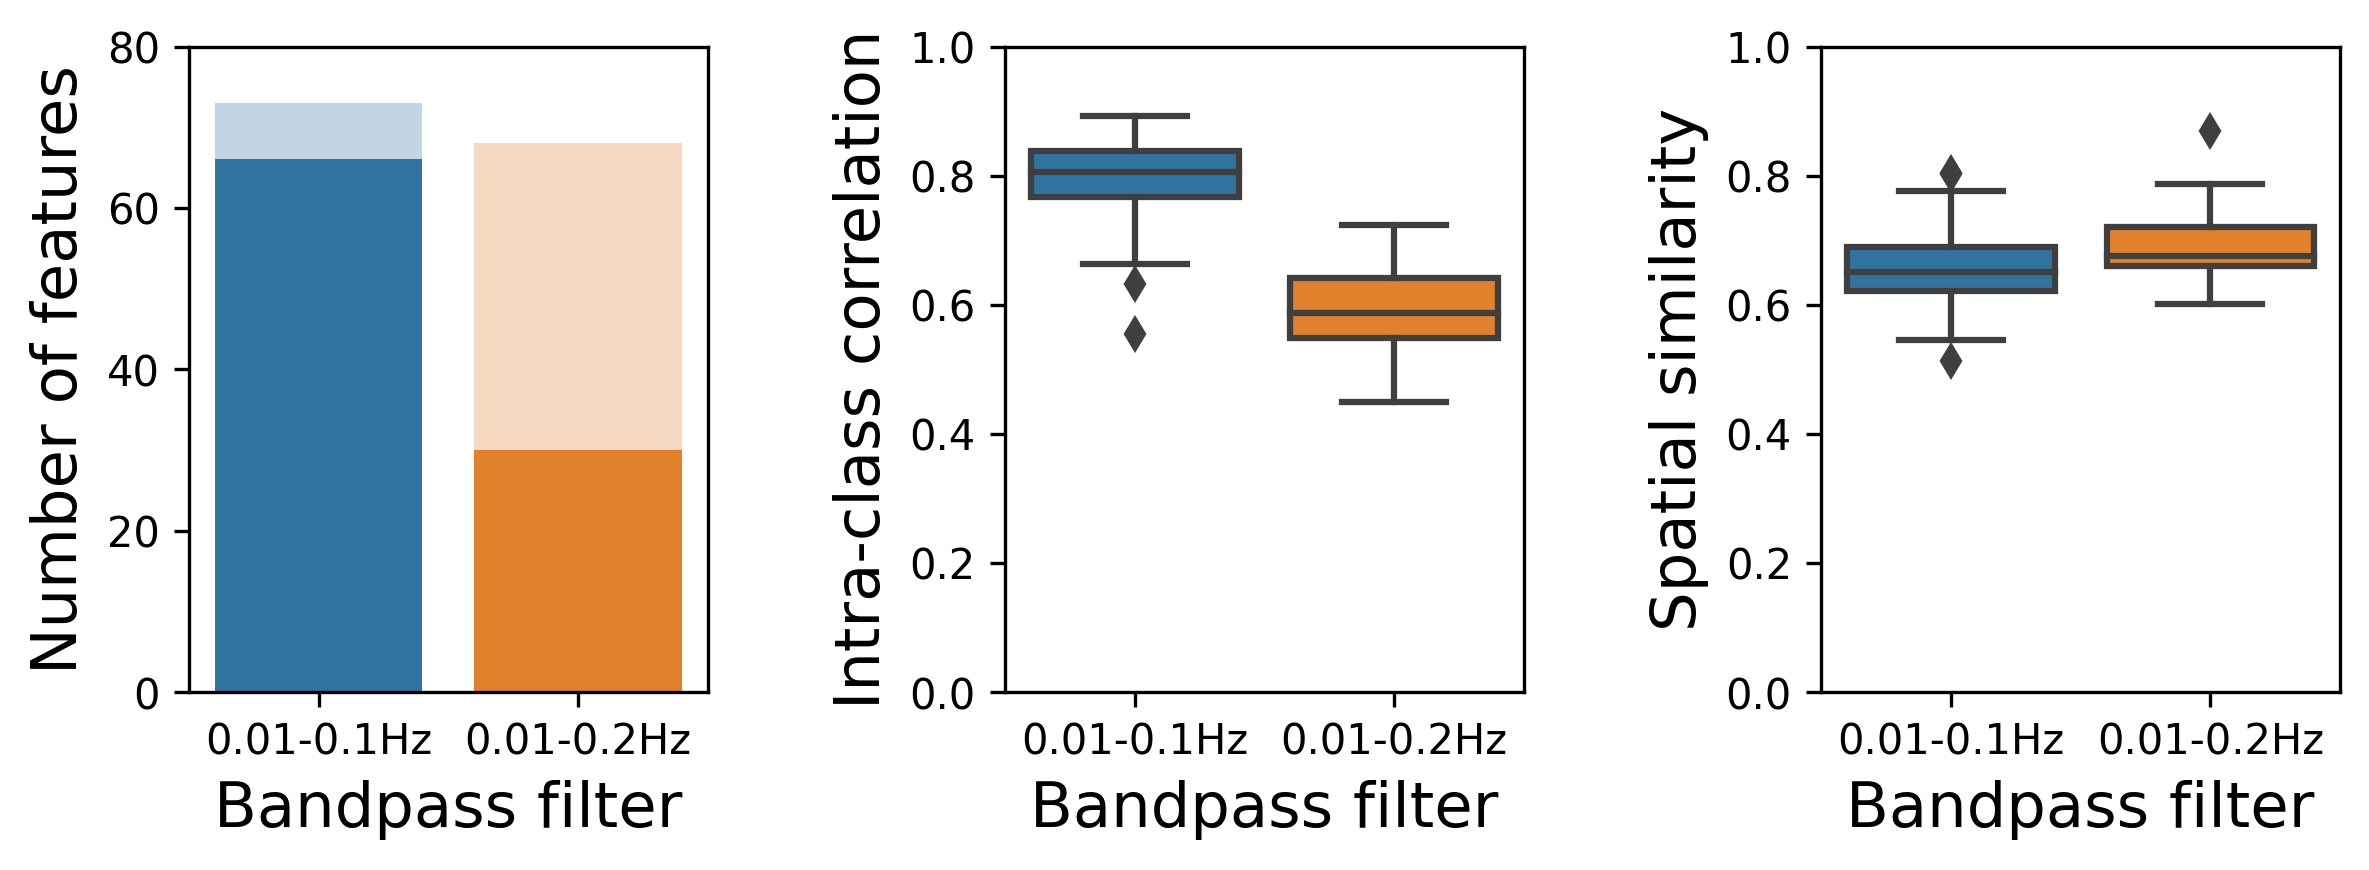

In [33]:
fig, axes = plt.subplots(1, 3, dpi=300, figsize=[8, 3])
label_size = 15

bar_dict = dict(cond=[], total=[], filtered=[])
for cond in ['E', 'B']:
    if cond == 'E':
        bar_dict['cond'].append('A')
    else:
        bar_dict['cond'].append(cond)
    bar_dict['total'].append(len(dataset.query('cond == @cond')))
    bar_dict['filtered'].append(len(dataset.query('cond == @cond and icc > 0.6 and sim > 0.6 and freq >= 4')))
    
bar_dict = pd.DataFrame(bar_dict)
    
sns.barplot(data=bar_dict.query('cond in ["A", "B"]'), x='cond', y='total', ax=axes[0], alpha=0.3)
sns.barplot(data=bar_dict.query('cond in ["A", "B"]'), x='cond', y='filtered', ax=axes[0])
sns.boxplot(data=dataset.query('cond in ["A", "B"]'), x='cond', y='icc', ax = axes[1])
sns.boxplot(data=dataset.query('cond in ["A", "B"]'), x='cond', y='sim', ax = axes[2])
cond1 = '0.01-0.1Hz'
cond2 = '0.01-0.2Hz'
axes[0].set_ylim(0, 80)
axes[0].set_xticklabels([cond1, cond2])
axes[0].set_xlabel('Bandpass filter', size=label_size)
axes[0].set_ylabel('Number of features', size=label_size)

axes[1].set_ylim(0, 1)
axes[1].set_xticklabels([cond1, cond2])
axes[1].set_xlabel('Bandpass filter', size=label_size)
axes[1].sezt_ylabel('Intra-class correlation', size=label_size)

axes[2].set_ylim(0, 1)
axes[2].set_xticklabels([cond1, cond2])
axes[2].set_xlabel('Bandpass filter', size=label_size)
axes[2].set_ylabel('Spatial similarity', size=label_size)

plt.tight_layout(pad=1.08, h_pad=None, w_pad=3, rect=None)

In [32]:
bar_dict

cond  total  filtered
0    E     73        66
1    B     68        30